In [64]:
#for evaluate

In [65]:
'''
실험은 여기서 진행하면 될거야
원래 run 함수 만들어서 한방에 돌아가도록 하려했는데 사용자한테 threshold 받아오려면 오히려 비효율적일것 같더라고
최종 목적은 웹이나 시각화 툴 혹은 python 시각화 라이브러리 이용하는 거니까 우선은 이 파일로 실험 진행하고 나중에 프로그램적으로 돌려야겠다 싶으면
그 때 만들어도 될 것 같다.

필요할 것 같은 함수들은 만들어 뒀는데 추가로 필수적인 함수 있으면 구현해서 사용하면 되고 기호에 맞게 수정해도 돼
그리고 함수 추가하거나 수정한 후에 PR 할때는 꼭 말해주고
'''

'\n실험은 여기서 진행하면 될거야\n원래 run 함수 만들어서 한방에 돌아가도록 하려했는데 사용자한테 threshold 받아오려면 오히려 비효율적일것 같더라고\n최종 목적은 웹이나 시각화 툴 혹은 python 시각화 라이브러리 이용하는 거니까 우선은 이 파일로 실험 진행하고 나중에 프로그램적으로 돌려야겠다 싶으면\n그 때 만들어도 될 것 같다.\n\n필요할 것 같은 함수들은 만들어 뒀는데 추가로 필수적인 함수 있으면 구현해서 사용하면 되고 기호에 맞게 수정해도 돼\n그리고 함수 추가하거나 수정한 후에 PR 할때는 꼭 말해주고\n'

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
# cd [your src path]
%cd /content/drive/MyDrive/bistelligence/BISTelligence/src

/content/drive/MyDrive/bistelligence/BISTelligence/src


In [68]:
%pip install pyod tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
%pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
import data.preprocessing as dp
import model.models as mm
from sklearn.utils.validation import check_is_fitted
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

In [71]:
path = '/content/drive/MyDrive/bistelligence/BIS_data/BISTelligen_Project_Data.csv'
threshold = 0

In [143]:
def GetLOF(scaled=True, key_num = -1):
  train_data, test_data = dp.GetPreprocessedData(path, scaled, key_num = key_num)
  model = mm.LOF(train_data, test_data)
  return model

In [144]:
def GetMCD(scaled=True, key_num = -1):
  train_data, test_data = dp.GetPreprocessedData(path, scaled, key_num = key_num)
  model = mm.MinimumCovarianceDeterminant(train_data, test_data)
  return model

In [145]:
def GetOCSVM(scaled=True, key_num = -1):
  train_data, test_data = dp.GetPreprocessedData(path, scaled, key_num = key_num)

  model = mm.OCSVM(train_data, test_data)
  return model

In [146]:
def GetGMM(scaled=True, key_num = -1):
  train_data, test_data = dp.GetPreprocessedData(path, scaled, key_num = key_num)

  model = mm.GausianMixtureModel(train_data, test_data)
  return model

In [147]:
def GetIForest(scaled=True, key_num = -1):
  train_data, test_data = dp.GetPreprocessedData(path, scaled, key_num = key_num)

  model = mm.IForest(train_data, test_data)
  return model

In [148]:
def GetAE(scaled=True, key_num = -1):
  train_data, test_data = dp.GetPreprocessedData(path, scaled, key_num = key_num)

  model = mm.AutoEncoder(train_data, test_data)
  return model

In [149]:
def GetAnomalyScore(model=None, scaled = True, key_num = -1):
  '''
  모델의 anomaly score return

  나중에 웹이나 시각화 툴로 health index 나타낼 때, (x,y)값 입력해야하는 경우 필요할 것 같아서 만듦.
  혹시 필요 없더라도 문제 없으니까 구현
  '''
  train_data, test_data = dp.GetPreprocessedData(path, scaled, key_num = key_num)

  #if check_is_fitted(model) == None:
  model_name = type(model).__name__

  if model_name == 'MCD':
    anomaly_score = model.decision_function(test_data)

  elif model_name in ['LocalOutlierFactor','GaussianMixture']:
    anomaly_score = -model.score_samples(test_data)

  elif model_name == 'OneClassSVM':
    anomaly_score = np.max(model.decision_function(test_data))-(model.decision_function(test_data))

  elif model_name == 'IsolationForest':
    anomaly_score = np.max(model.score_samples(test_data))-(model.score_samples(test_data))

  else:
    reconstruction = model.predict(test_data)
    mse = np.mean(np.power(test_data-reconstruction,2),axis=1)
    anomaly_score = ss.zscore(mse)
  return anomaly_score

In [150]:
def ShowHealthIndex(model = None, anomaly_score = None, scaled = True, key_num = -1):
  '''
  GetAnomalyScore로 이상치 점수 받아온 후, health index plot을 도출
  png로 저장 혹은 단순 plot 도출
  '''
  plt.rcParams['figure.figsize'] = (12, 8)
  model_name = type(model).__name__
  if model_name == 'Sequential':
    model_name = 'AutoEncoder'
  sns.scatterplot(range(len(anomaly_score)), anomaly_score)
  plt.title('{} health index key = {} (scaled ={}) '.format(model_name, key_num, scaled), fontsize = 25)
  plt.show()
  return

In [151]:
def DoXAI(model=None):
  '''
  더 잘맞는 함수 이름으로 바꿔도 괜찮고, 파라미터도 상황에 맞게 변경 가능
  (threshold를 입력받아야 XAI가 진행될 수도 있다고 생각되는데 그럴 경우, SetThreshold() 함수를 만들어서 threshold에 값 저장시킬 필요 있음.)
  XAI 폴더의 xai.py(가명)의 함수들을 실행시키는 함수
  
  xai.py(가명)의 함수들은 shap에서 지원하는 여러가지 plot을 그리고, png 파일로 XAI 폴더 내에 저장하는 동작으로 가정
  따라서 DoXAI()를 실행하면 XAI 폴더 내에 여러 plot png파일이 생성되는것을 생각하고 만듦
  '''  
  pass

In [152]:
def SaveBestModel(model):
  # model.best_model 폴더에 모델 저장
  %cd /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model
  filename = '_'.join(['best', type(model).__name__])
  joblib.dump(model, filename)


In [82]:
def LoadBestModel(model):
  %cd /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model
  filename = '_'.join(['best', type(model).__name__])
  model = joblib.load(filename)
  return model

In [83]:
# GetLOF, GetMCD, GetOCSVM, GetIForest, GetAE, GetGMM

# MCD, GMM, LOF 큰 차이 없음

# isolationforest 성능 그냥 구림
# ocsvm은 health index y scale이 작아짐

# AE는 key 나눠서 하기 전보다 KEY 5,6 z-score 좋아짐
# 모델학습이 잘 됐다고 보기는 어렵고 표준화 영향

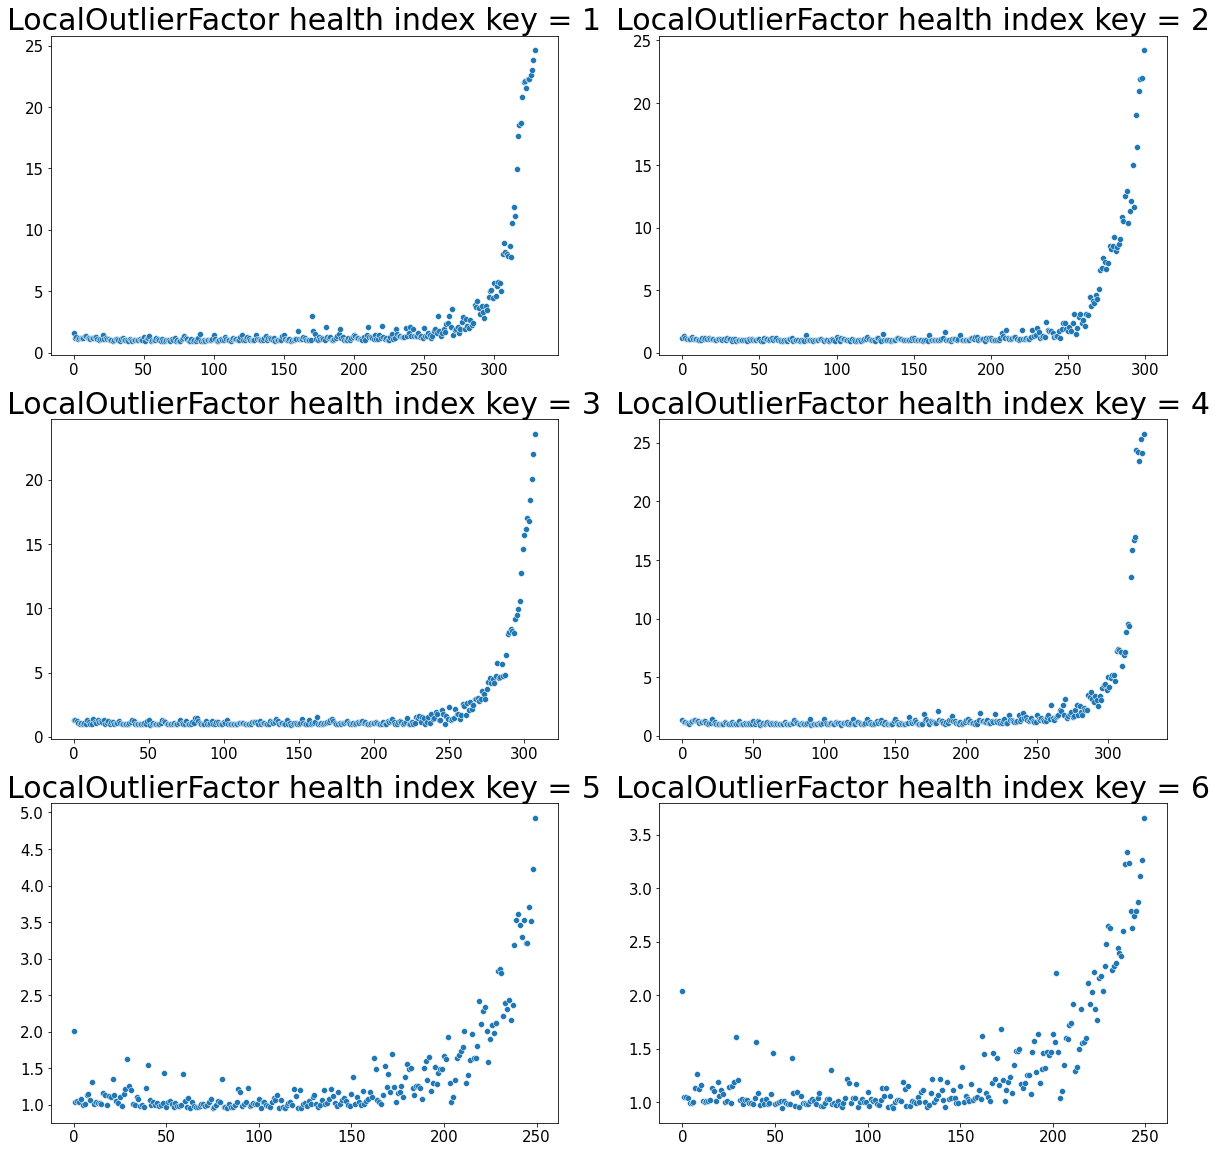

In [153]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    model = GetLOF(key_num = i)
    model_name = type(model).__name__
    score = GetAnomalyScore(model, key_num = i)
    sns.scatterplot(range(len(score)), score)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)

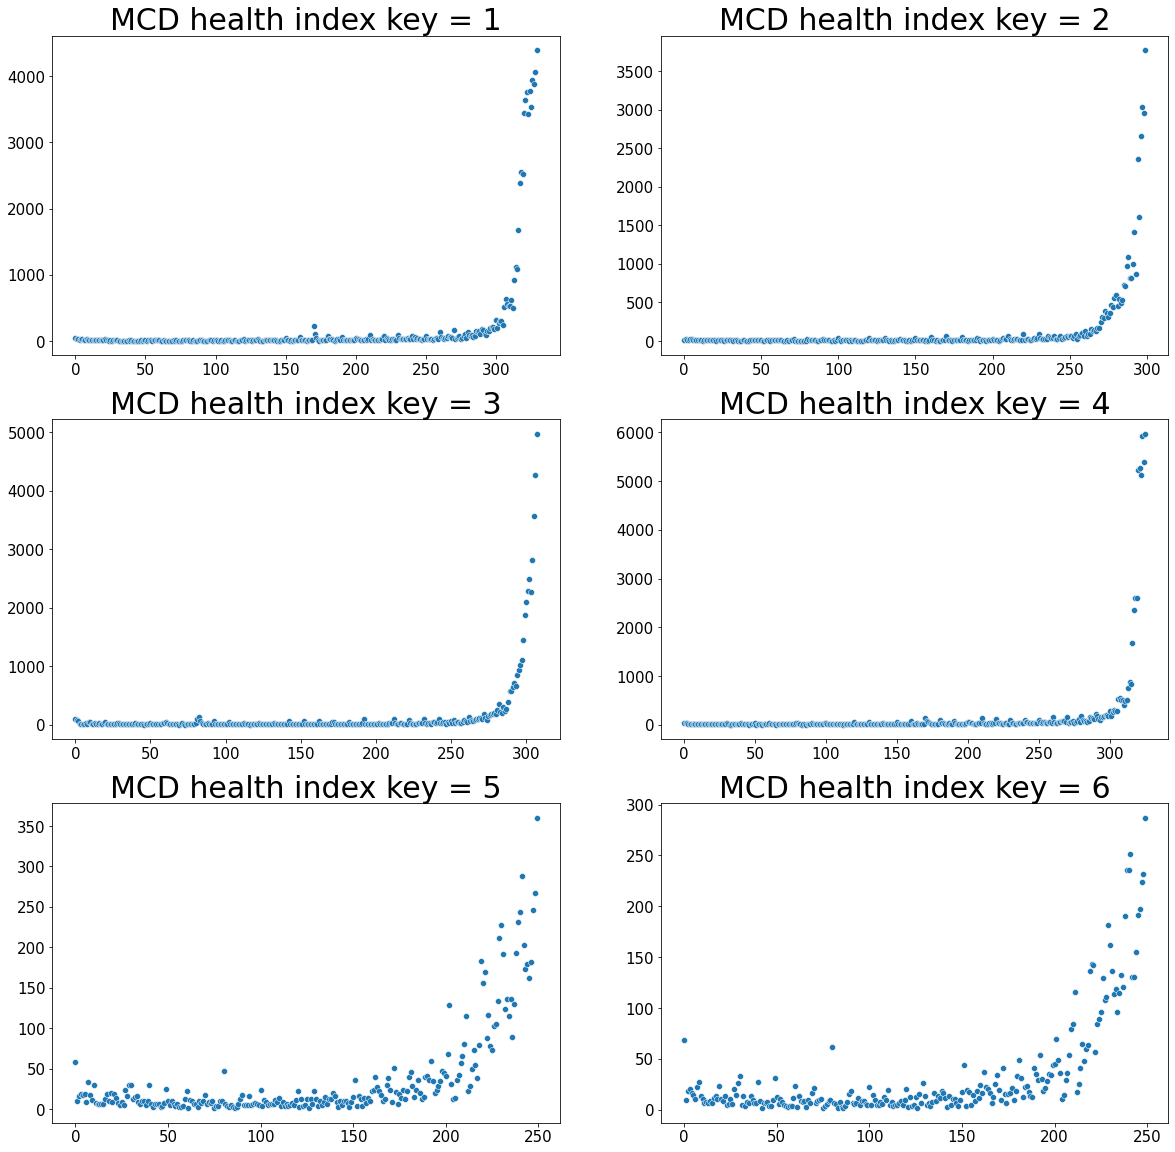

In [154]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    model = GetMCD(key_num = i)
    model_name = type(model).__name__
    score = GetAnomalyScore(model, key_num = i)
    sns.scatterplot(range(len(score)), score)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)

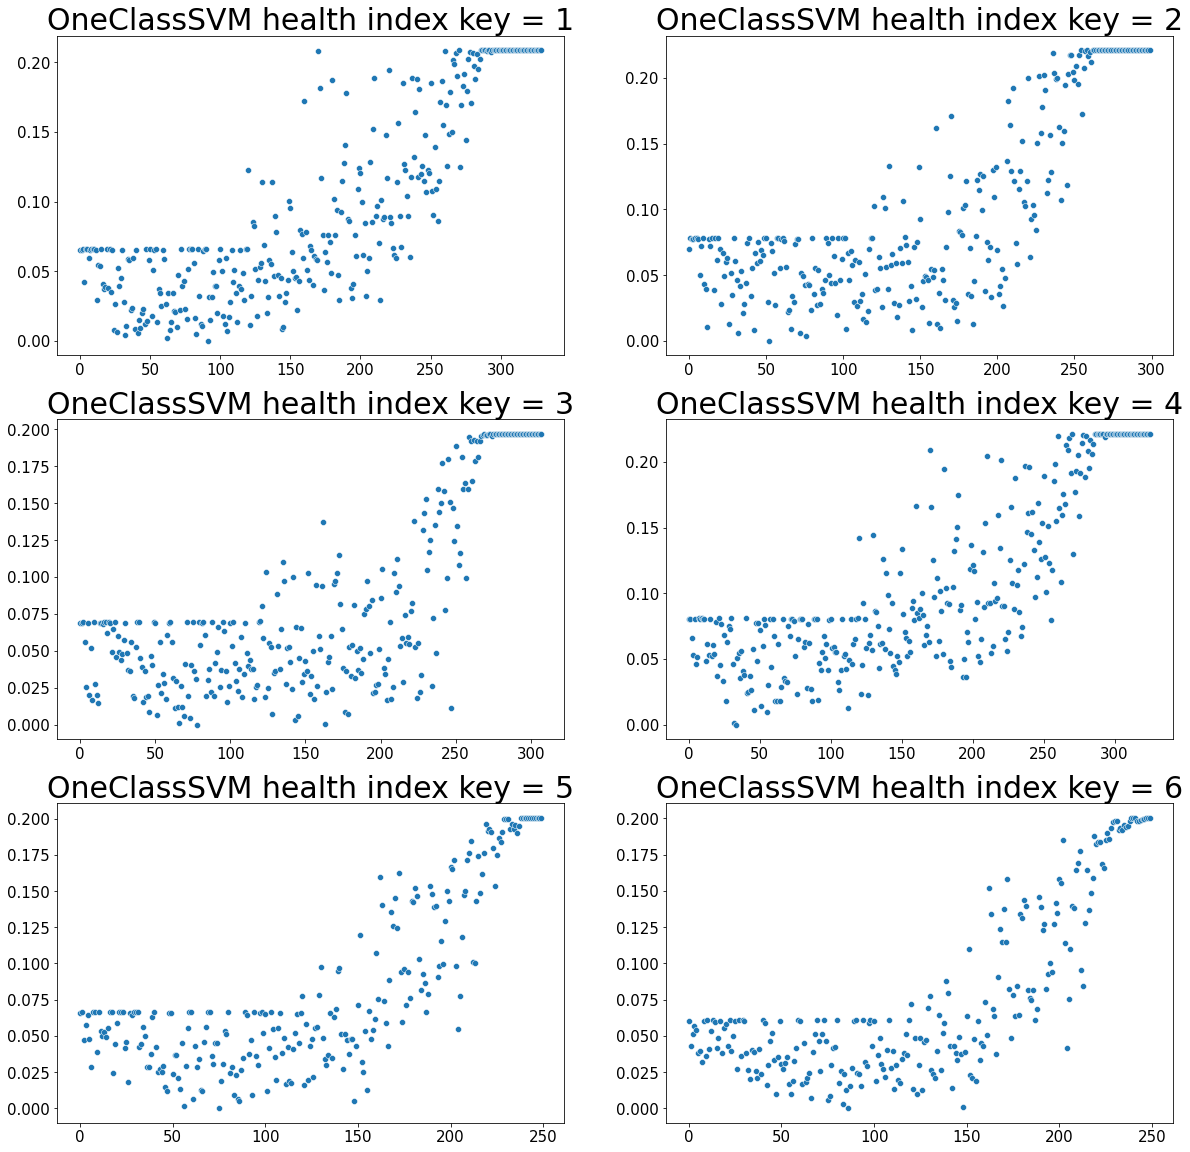

In [155]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    model = GetOCSVM(key_num = i)
    model_name = type(model).__name__
    score = GetAnomalyScore(model, key_num = i)
    sns.scatterplot(range(len(score)), score)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)

gmm model is converged
gmm model is converged
gmm model is converged
gmm model is converged
gmm model is converged
gmm model is converged


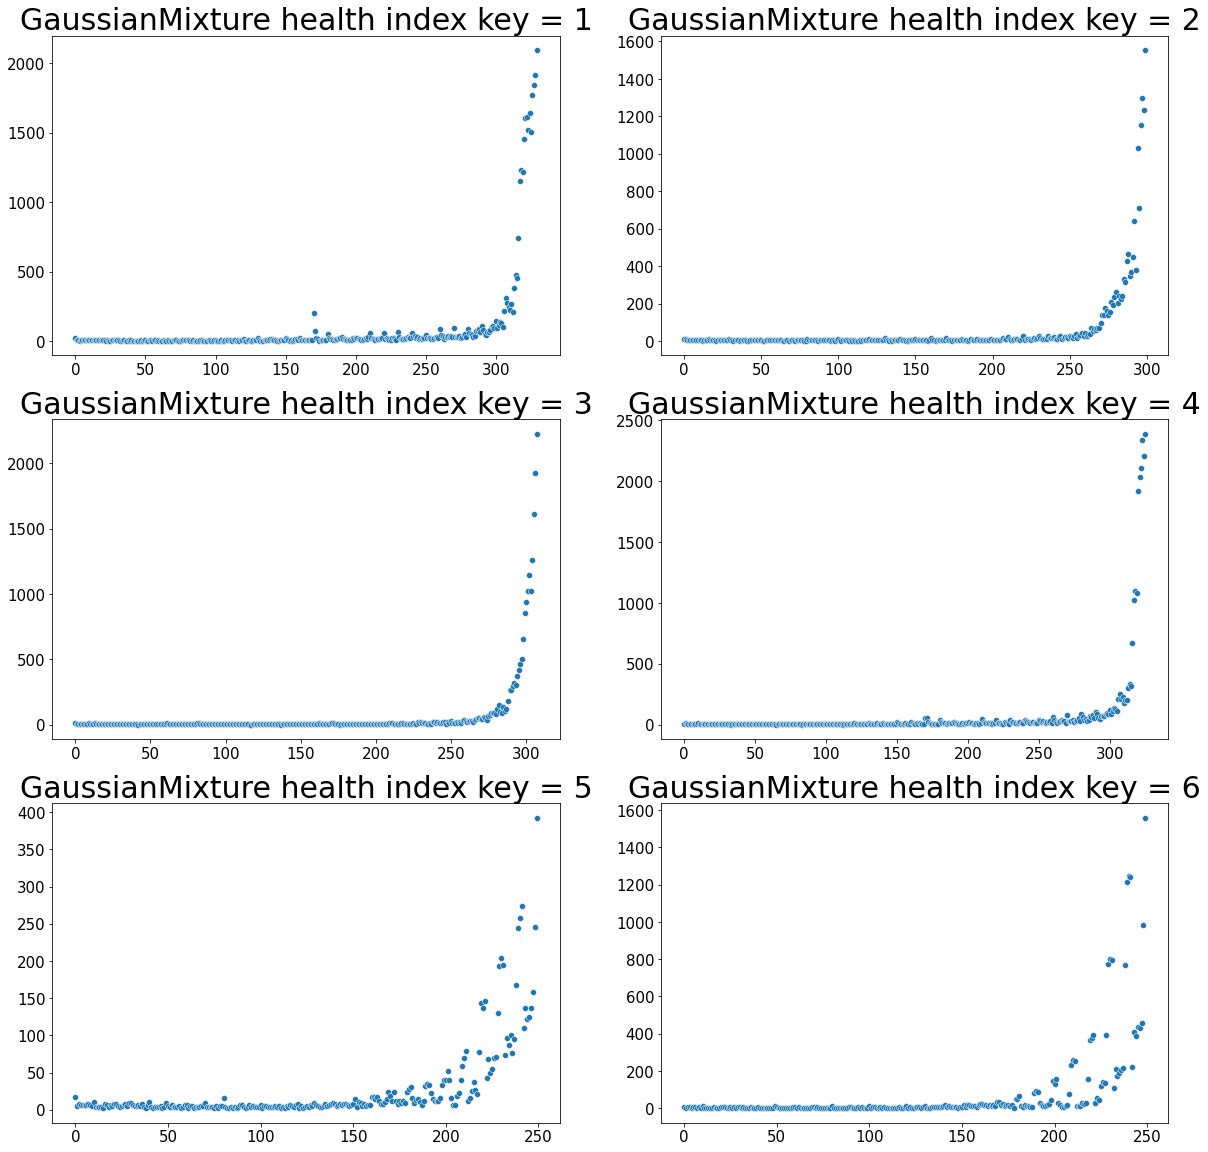

In [156]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    model = GetGMM(key_num = i)
    model_name = type(model).__name__
    score = GetAnomalyScore(model, key_num = i)
    sns.scatterplot(range(len(score)), score)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)

Epoch 46: early stopping
11/11 [==============================] - 0s 2ms/step
Epoch 23: early stopping
10/10 [==============================] - 0s 3ms/step
Epoch 59: early stopping
10/10 [==============================] - 0s 2ms/step
Epoch 73: early stopping
11/11 [==============================] - 0s 2ms/step
Epoch 27: early stopping
8/8 [==============================] - 0s 4ms/step
Epoch 63: early stopping
8/8 [==============================] - 0s 3ms/step


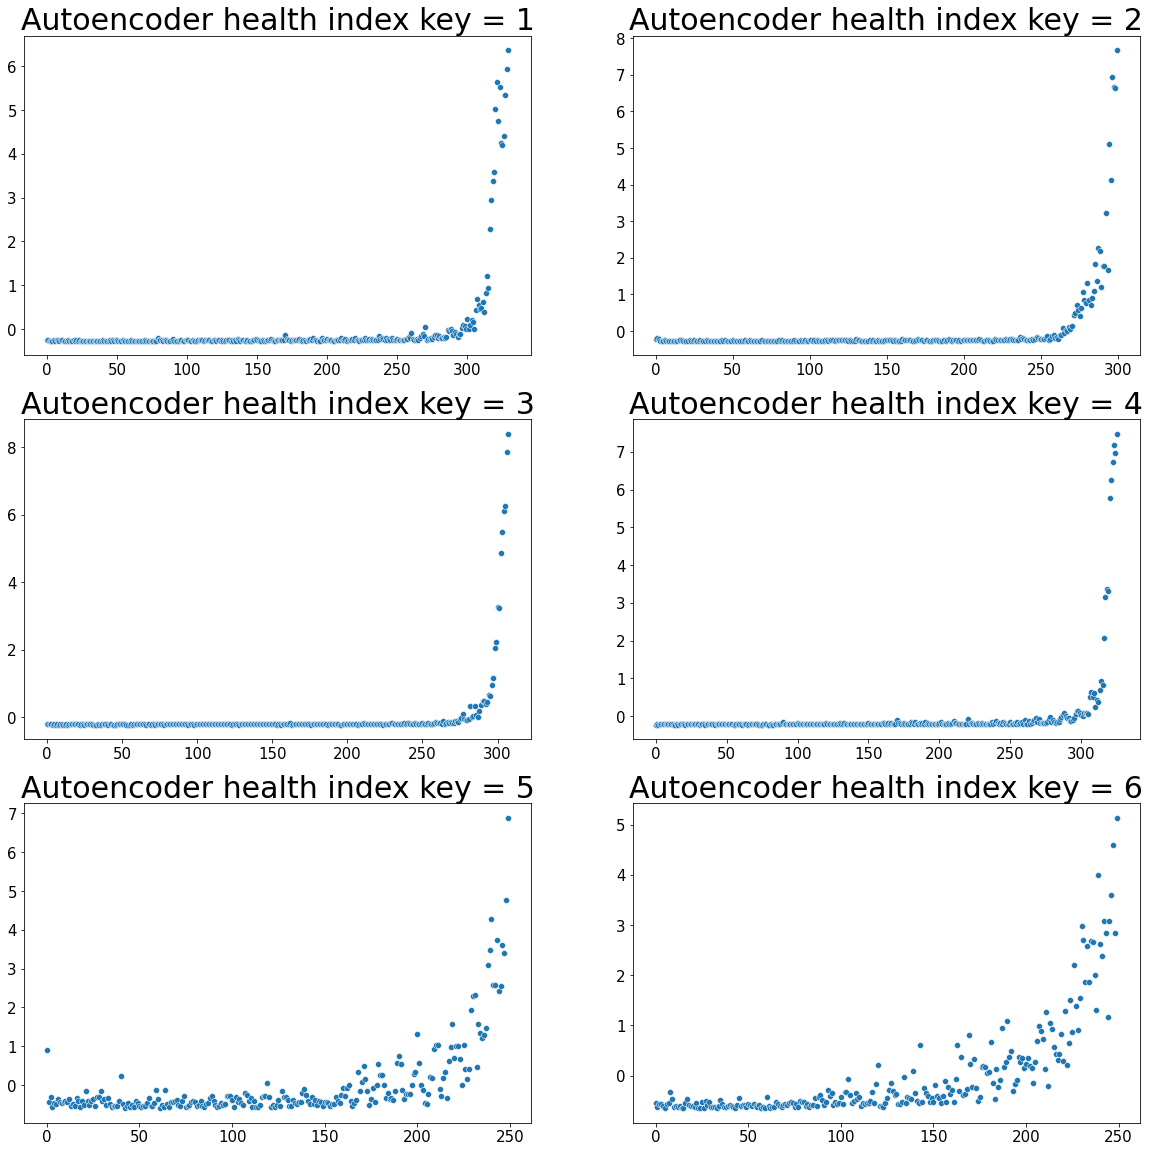

In [157]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    model = GetAE(key_num = i)
    model_name = type(model).__name__
    if model_name == 'Sequential':
      model_name = 'Autoencoder'
    score = GetAnomalyScore(model, key_num = i)
    sns.scatterplot(range(len(score)), score)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)

# scaling x

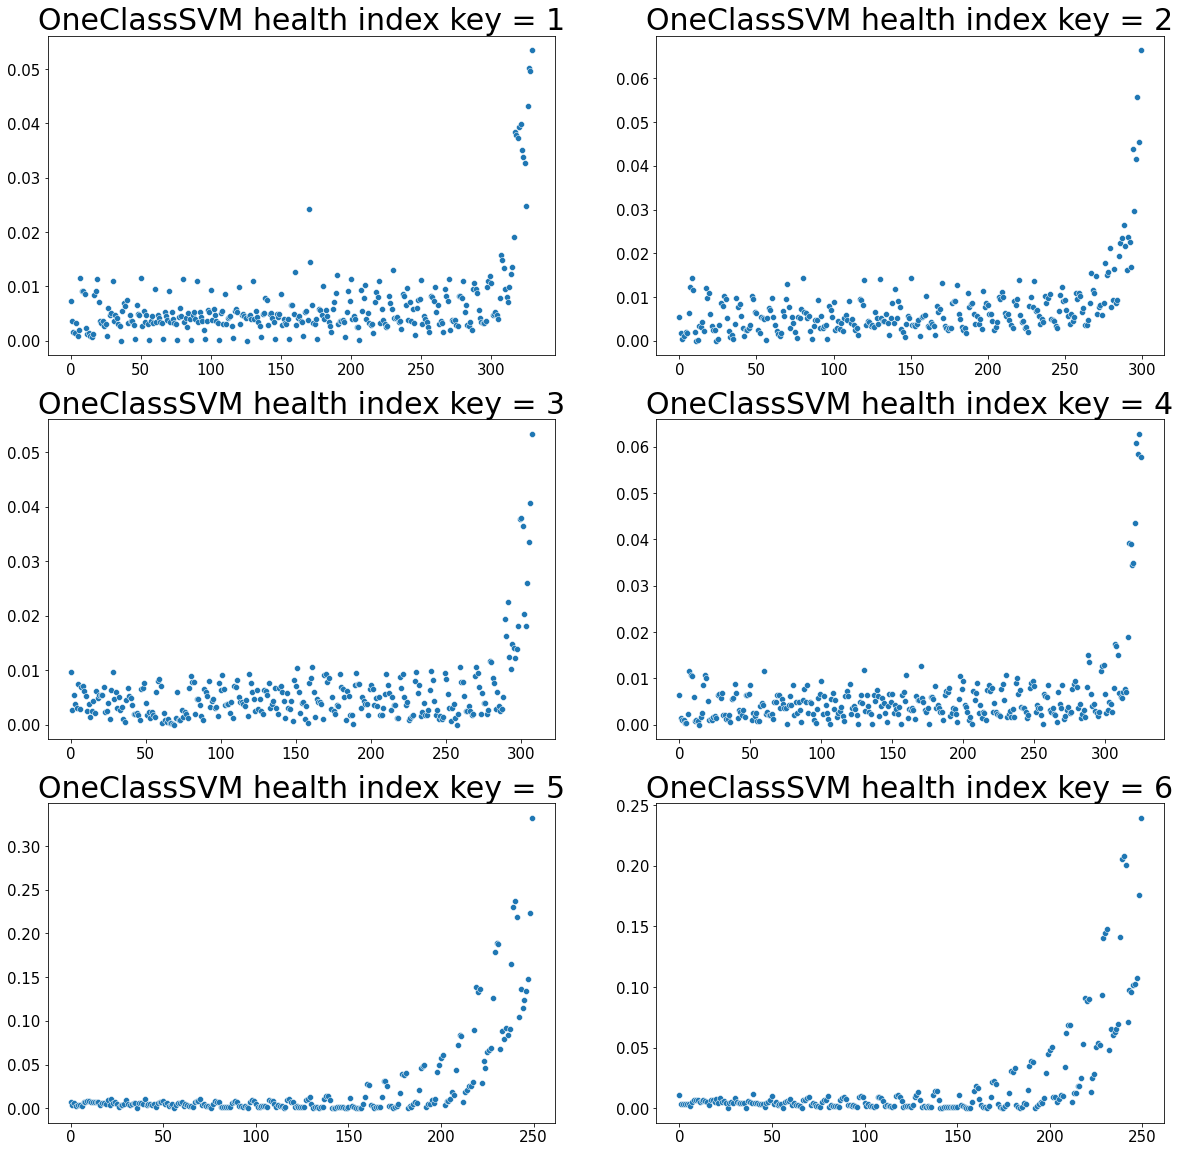

In [158]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    model = GetOCSVM(key_num = i, scaled = False)
    model_name = type(model).__name__
    score = GetAnomalyScore(model, key_num = i, scaled = False)
    sns.scatterplot(range(len(score)), score)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)

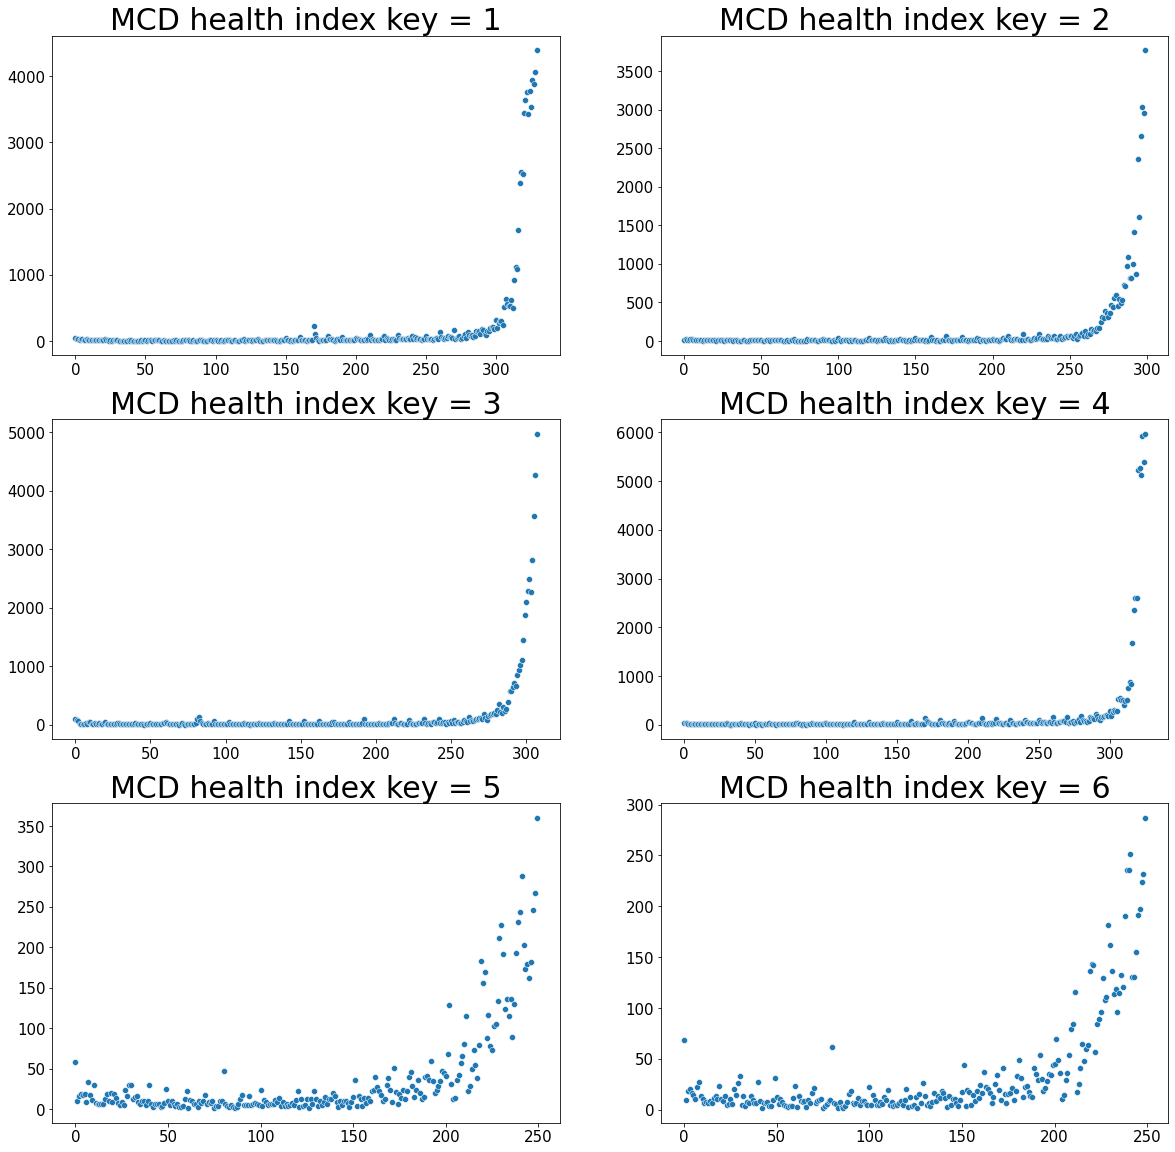

In [159]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    model = GetMCD(key_num = i, scaled = False)
    model_name = type(model).__name__
    score = GetAnomalyScore(model, key_num = i, scaled = False)
    sns.scatterplot(range(len(score)), score)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)

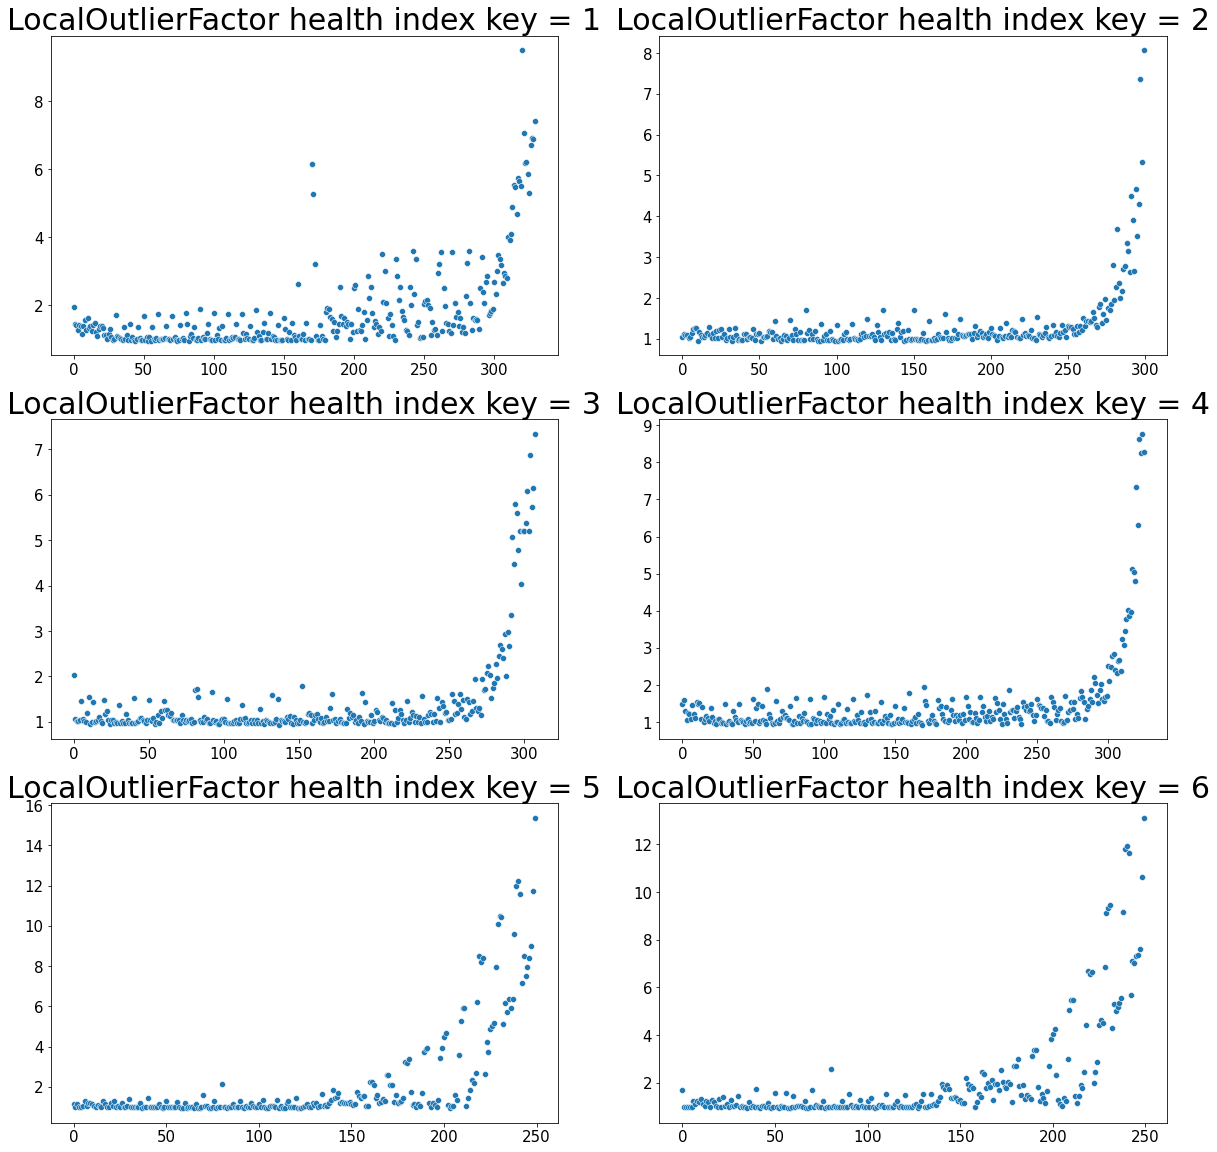

In [160]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    model = GetLOF(key_num = i, scaled = False)
    model_name = type(model).__name__
    score = GetAnomalyScore(model, key_num = i, scaled = False)
    sns.scatterplot(range(len(score)), score)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)

gmm model is converged
gmm model is converged
gmm model is converged
gmm model is converged
gmm model is converged
gmm model is converged


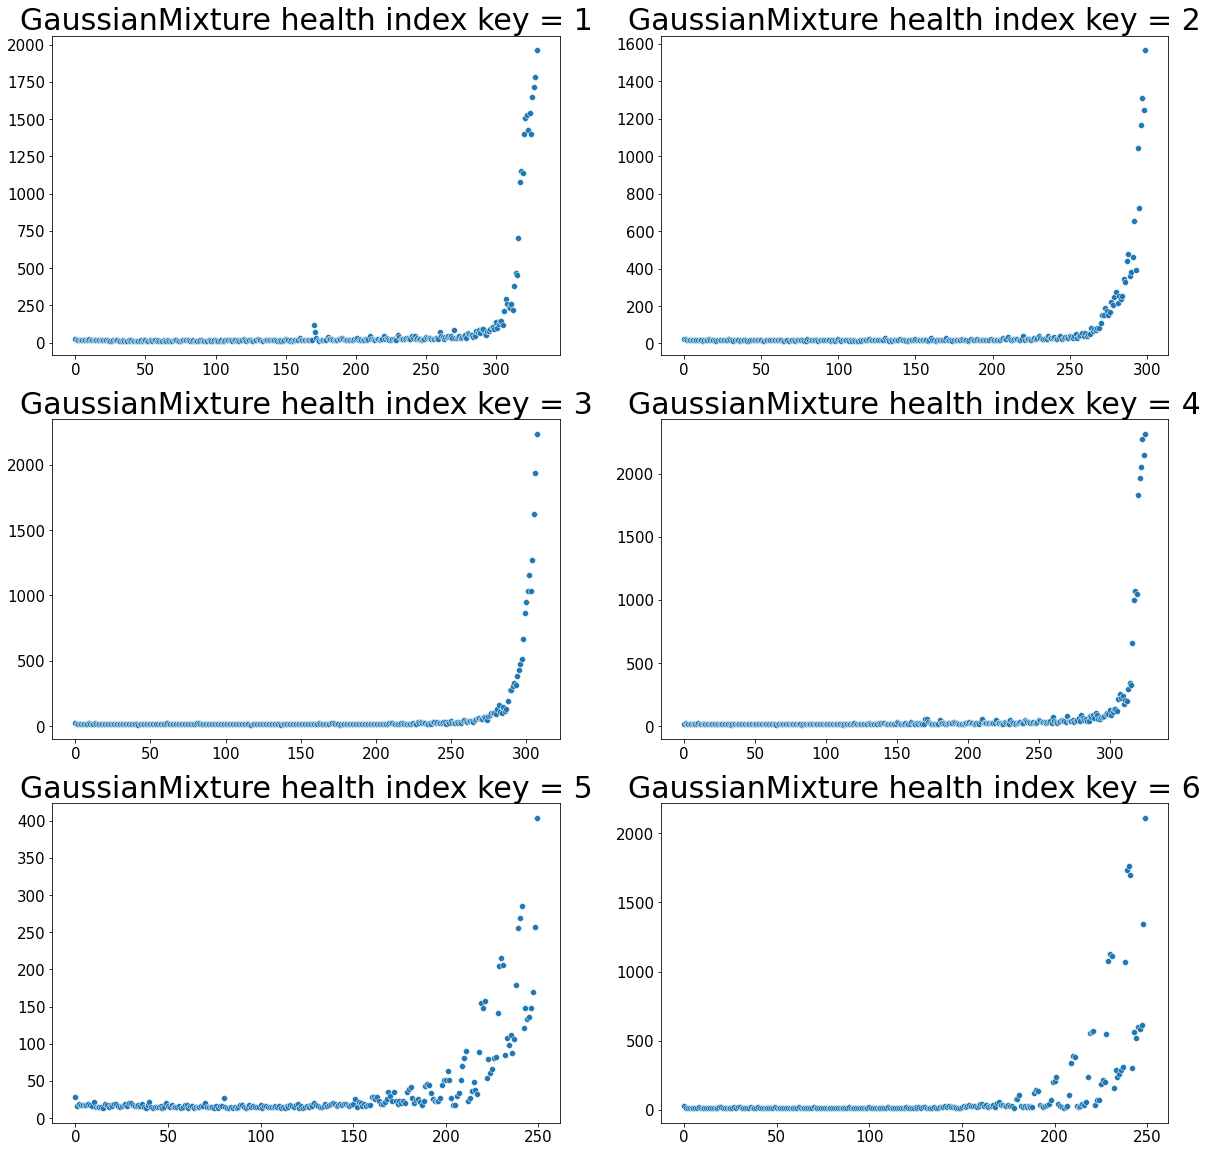

In [162]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    model = GetGMM(key_num = i, scaled = False)
    model_name = type(model).__name__
    score = GetAnomalyScore(model, key_num = i, scaled = False)
    sns.scatterplot(range(len(score)), score)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)